# Extract annotations and data from OMIM

The purpose of this notebook is to extract and format OMIM data for subsequent model annotation.

Additionally, the purpose of this notebook is to extract relevant data about morbid SNPs and phenotypes from the database.

## Notebook Requirements:
*  Model genes **must** have the at least one of following annotations stored in the `object.annotation`. Values are expected to be seperated by semicolons. Accepted keys currently include:
    * `"ncbigene"`
    * `"hgnc.symbol"` 
    * `"ensembl"`
    * `"mim"`

## OMIM® - Online Mendelian Inheritance in Man®
To utilize this notebook: 

1. Go to [OMIM database](https://omim.org/) and submit a request to download files.
2. Follow the instructions to obtain download access for MIM files.
3. After receiving access (check email), download the following files:
    * `mim2gene.txt`: A tab-delimited file linking MIM numbers with NCBI Gene IDs, Ensembl Gene IDs, and HGNC Approved Gene Symbols.
    * `mimTitles.txt`A tab-delimited file of MIM numbers and titles.
    * `genemap2.txt`A tab-delimited file containing OMIM's Synopsis of the Human Gene Map including additional information such as genomic coordinates and inheritance.
    * `morbidmap.txt`A tab-delimited file of OMIM's Synopsis of the Human Gene Map (same as `genemap2.txt` above) sorted alphabetically by disorder.
4. Remember clear out any personal account information and ensure the downloaded OMIM file(s) remains local!

### Citations
Hamosh A, Scott AF, Amberger JS, Bocchini CA, McKusick VA. Online Mendelian Inheritance in Man (OMIM), a knowledgebase of human genes and genetic disorders. Nucleic Acids Res. 2005 Jan 1;33(Database issue):D514-7. doi: 10.1093/nar/gki033. PMID: 15608251; PMCID: PMC539987.


### Import packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from rbc_gem_utils import (
    ANNOTATION_PATH,
    COBRA_CONFIGURATION,
    DATABASE_PATH,
    GEM_NAME,
    INTERIM_PATH,
    ROOT_PATH,
    build_string,
    compare_tables,
    get_annotation_df,
    get_annotation_dirpath,
    get_database_dirpath,
    read_rbc_model,
    show_versions,
    split_string,
    visualize_comparison,
)
from rbc_gem_utils.database.mim import (
    MIM_DB_TAG,
    MIM_NUMBER_RE,
    MIM_PATH,
    get_last_updated_dates_MIM,
    load_data_MIM,
)

show_versions()


Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Information
-------------------

## Set notebook options

In [2]:
db_tag = MIM_DB_TAG

# Compare to/Overwrite previous files
compare_figsize = (5, 5)
compare = True
display_nunique = True
overwrite = True
print_footer_notes = False

# Best mapping keys are hgnc.symbol or mim
mapping_key = "hgnc.symbol"

## Check OMIM version
If the version does not match the expected version, it is because database has been updated since the last time this code was utilized. 
* Major updates appear to be monthly. See last update [here](https://omim.org/statistics/update).
* Data files are updated nightly.

In [3]:
use_interim = False
database_dirpath = get_database_dirpath(db_tag, use_interim=use_interim)
annotation_dirpath = get_annotation_dirpath(use_interim=use_interim)

# Ensure directories exist
database_dirpath.mkdir(exist_ok=True, parents=True)
annotation_dirpath.mkdir(exist_ok=True, parents=True)

In [4]:
last_updated = get_last_updated_dates_MIM(database_dirpath)

Files last generated on: 2025-05-02


## Load RBC-GEM model

In [5]:
model = read_rbc_model(filetype="xml")
model

Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-21


Name,RBC_GEM
Memory address,14f8c3d90
Number of metabolites,2157
Number of reactions,3275
Number of genes,820
Number of groups,78
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


### Determine mapping method
#### Load model annotations of relevance

In [6]:
annotation_type = "genes"
annotation_cols = ["ncbigene", "hgnc.symbol", "ensembl", "mim"]

df_model_mappings = (
    get_annotation_df(model.genes, annotation_cols)
    .rename({"id": annotation_type}, axis=1)
    .dropna(subset=[mapping_key])
)
for col in df_model_mappings.columns:
    df_model_mappings[col] = df_model_mappings[col].apply(lambda x: split_string(x))
    df_model_mappings = df_model_mappings.explode(col).drop_duplicates()
df_model_mappings = df_model_mappings.sort_values(annotation_type)

print(df_model_mappings.nunique(dropna=True))
df_model_mappings = df_model_mappings.reset_index(drop=True)
df_model_mappings

genes          820
ncbigene       825
hgnc.symbol    821
ensembl        557
mim            889
dtype: int64


,genes,ncbigene,hgnc.symbol,ensembl,mim
0,A4GALT,53947,A4GALT,ENSG00000128274,607922
1,A4GALT,53947,A4GALT,ENSG00000128274,111400
2,AARS1,16,AARS1,ENSG00000090861,619691
3,AARS1,16,AARS1,ENSG00000090861,619661
4,AARS1,16,AARS1,ENSG00000090861,616339
...,...,...,...,...,...
1212,YES1,7525,YES1,<NA>,<NA>
1213,ZDHHC2,51201,ZDHHC2,ENSG00000104219,618621
1214,ZDHHC20,253832,ZDHHC20,ENSG00000180776,617972
1215,ZDHHC3,51304,ZDHHC3,ENSG00000163812,617150


#### Get query IDs

In [7]:
print(f"Mapping key: {mapping_key}")
query_ids = df_model_mappings[mapping_key].dropna().unique()
assert len(set(query_ids)) == len(query_ids), "Duplicate IDs in list to query"
model_search_mapping = df_model_mappings.set_index(annotation_type)[
    mapping_key
].to_dict()
print(f"Number of model genes associated with query: {len(model_search_mapping)}")
print(f"Number of unique IDs to query: {len(query_ids)}")
df_model_mappings[[annotation_type, mapping_key]].drop_duplicates()

Mapping key: hgnc.symbol
Number of model genes associated with query: 820
Number of unique IDs to query: 821


,genes,hgnc.symbol
0,A4GALT,A4GALT
2,AARS1,AARS1
7,AASDHPPT,AASDHPPT
8,ABCA1,ABCA1
11,ABCA7,ABCA7
...,...,...
1212,YES1,YES1
1213,ZDHHC2,ZDHHC2
1214,ZDHHC20,ZDHHC20
1215,ZDHHC3,ZDHHC3


## Load MIM data
### MIM Numbers and types

In [8]:
df_mim = load_data_MIM("mim2gene", print_footer_notes=print_footer_notes).fillna("")
df_mim = df_mim.rename(
    {
        "# MIM Number": "mim",
        "Entrez Gene ID (NCBI)": "ncbigene",
        "Approved Gene Symbol (HGNC)": "hgnc.symbol",
        "Ensembl Gene ID (Ensembl)": "ensembl",
        "MIM Entry Type (see FAQ 1.3 at https://omim.org/help/faq)": "type",
    },
    axis=1,
)
df_mim.head()

,mim,type,ncbigene,hgnc.symbol,ensembl
0,100050,predominantly phenotypes,,,
1,100070,phenotype,100329167,,
2,100100,phenotype,,,
3,100200,predominantly phenotypes,,,
4,100300,phenotype,,,


### Morbid Map

In [9]:
df_morbidmap = load_data_MIM("morbidmap", print_footer_notes=print_footer_notes).fillna(
    ""
)
df_morbidmap["Gene/Locus And Other Related Symbols"] = df_morbidmap[
    "Gene/Locus And Other Related Symbols"
].apply(lambda x: x.split(", ")[0])
rename_mapping = {
    "MIM Number": "mim",
    "# Phenotype": "phenotype",
    "Cyto Location": "cyto.location",
    "Gene/Locus And Other Related Symbols": "morbid.symbol",
}
df_morbidmap = df_morbidmap.loc[:, list(rename_mapping)].rename(rename_mapping, axis=1)
df_morbidmap["mim.phenotype"] = df_morbidmap["phenotype"].apply(
    lambda phenotype: build_string(
        [
            MIM_NUMBER_RE.search(s).group()
            for s in split_string(phenotype, sep=" ")
            if MIM_NUMBER_RE.search(s)
        ]
    )
)
df_morbidmap.head()

,mim,phenotype,cyto.location,morbid.symbol,mim.phenotype
0,609300,"17,20-lyase deficiency, isolated, 202110 (3)",10q24.32,CYP17A1,202110
1,609300,"17-alpha-hydroxylase/17,20-lyase deficiency, 2...",10q24.32,CYP17A1,202110
2,615787,"2,4-dienoyl-CoA reductase deficiency, 616034 (3)",5p13.2,NADK2,616034
3,600301,"2-methylbutyrylglycinuria, 610006 (3)",10q26.13,ACADSB,610006
4,609577,"3-M syndrome 1, 273750 (3)",6p21.1,CUL7,273750


### Gene Map

In [10]:
df_genemap = load_data_MIM("genemap2", print_footer_notes=print_footer_notes).fillna("")
# # Seperate mouse genes IDs
# df_model_mim_final["Mouse Gene Symbol"] = df_model_mim_final["Mouse Gene Symbol/ID"].fillna("").apply(lambda x: x.split(" ")[0])
# df_model_mim_final["Mouse Gene Symbol"] = df_model_mim_final["Mouse Gene Symbol"].str.replace(",", ";")
df_genemap["Mouse Gene ID"] = (
    df_genemap["Mouse Gene Symbol/ID"]
    .fillna("")
    .apply(lambda x: x.split(" ")[-1].lstrip("(").rstrip(")"))
)

df_genemap["Mouse Gene ID"] = df_genemap["Mouse Gene ID"].str.replace(",", ";")
# df_genemap["Mouse Gene ID"] = df_genemap["Mouse Gene ID"].str.replace("MGI:", "")

rename_mapping = {
    "# Chromosome": "chromosome",
    "Cyto Location": "cyto.location",
    "MIM Number": "mim",
    "Approved Gene Symbol": "hgnc.symbol",
    "Entrez Gene ID": "ncbigene",
    "Ensembl Gene ID": "ensemble",
    "Phenotypes": "phenotype",
    "Mouse Gene ID": "mgi",
}
df_genemap = df_genemap.loc[:, list(rename_mapping)].rename(rename_mapping, axis=1)
df_genemap["mim.phenotype"] = df_genemap["phenotype"].apply(
    lambda phenotype: build_string(
        [
            MIM_NUMBER_RE.search(s).group()
            for s in split_string(phenotype, sep=" ")
            if MIM_NUMBER_RE.search(s)
        ]
    )
)
df_genemap = df_genemap[
    df_genemap[mapping_key].isin(list(model_search_mapping.values()))
].reset_index(drop=True)
df_genemap

,chromosome,cyto.location,mim,hgnc.symbol,ncbigene,ensemble,phenotype,mgi,mim.phenotype
0,chr1,1p36,176982,PRKCZ,5590,ENSG00000067606,,MGI:97602,
1,chr1,1p36,606162,PANK4,55229,ENSG00000157881,"?Cataract 49, 619593 (3), Autosomal dominant",MGI:2387466,619593
2,chr1,1p36.3,601142,KCNAB2,8514,ENSG00000069424,,MGI:109239,
3,chr1,1p36,602587,ACOT7,11332,ENSG00000097021,,MGI:1917275,
4,chr1,1p36,602533,PARK7,11315,ENSG00000116288,"Parkinson disease 7, autosomal recessive early...",MGI:2135637,606324
...,...,...,...,...,...,...,...,...,...
811,chrX,Xq28,300036,SLC6A8,6535,ENSG00000130821,"Cerebral creatine deficiency syndrome 1, 30035...",MGI:2147834,300352
812,chrX,Xq28,300197,ATP6AP1,537,ENSG00000071553,"Immunodeficiency 47, 300972 (3), X-linked rece...",MGI:109629,300972
813,chrX,Xq28,305900,G6PD,2539,ENSG00000160211,"Anemia, congenital, nonspherocytic hemolytic, ...",MGI:105977;MGI:105979,300908;611162
814,chrX,Xq28,300138,CLIC2,1193,ENSG00000155962,,,


### Titles

In [11]:
df_mimtitles = load_data_MIM("mimTitles", print_footer_notes=print_footer_notes).fillna(
    ""
)
rename_mapping = {
    "MIM Number": "mim",
    "Preferred Title; symbol": "title",
}
df_mimtitles = df_mimtitles.loc[:, list(rename_mapping)].rename(rename_mapping, axis=1)
df_mimtitles["title"] = df_mimtitles["title"].apply(lambda x: split_string(x))
df_mimtitles["title.symbol"] = df_mimtitles["title"].apply(
    lambda x: x[-1] if len(x) > 1 else ""
)
df_mimtitles["title"] = df_mimtitles["title"].apply(lambda x: x[0])

df_mimtitles.head()

,mim,title,title.symbol
0,100050,"AARSKOG SYNDROME, AUTOSOMAL DOMINANT",
1,100070,"AORTIC ANEURYSM, FAMILIAL ABDOMINAL, 1",AAA1
2,100100,PRUNE BELLY SYNDROME,PBS
3,100200,ABDUCENS PALSY,
4,100300,ADAMS-OLIVER SYNDROME 1,AOS1


## Map to model

In [12]:
df_model_mim = (
    pd.merge(
        df_model_mappings[[annotation_type, mapping_key]].drop_duplicates(),
        df_mim,
        left_on=mapping_key,
        right_on=mapping_key,
        how="left",
        suffixes=("", "_drop"),
    )
    .merge(
        df_morbidmap, left_on="mim", right_on="mim", how="left", suffixes=("", "_drop")
    )
    .merge(
        df_genemap, left_on="mim", right_on="mim", how="left", suffixes=("", "_drop")
    )
    .merge(
        df_mimtitles, left_on="mim", right_on="mim", how="left", suffixes=("", "_drop")
    )
)
df_removed_mim = df_model_mim[df_model_mim["type"] == "moved/removed"]
df_model_mim = df_model_mim[df_model_mim["type"] != "moved/removed"].reset_index(
    drop=True
)
df_model_mim = df_model_mim.drop(
    [c for c in df_model_mim.columns if c.endswith("_drop")], axis=1
).drop_duplicates()

df_model_mim["mim.all"] = df_model_mim[["mim", "mim.phenotype"]].apply(
    lambda x: build_string(sorted(set(x.dropna().unique()))), axis=1
)
df_model_mim = df_model_mim[df_model_mim["type"].str.find("gene") == 0]
df_model_mim = df_model_mim.sort_values(annotation_type).reset_index(drop=True)

df = df_mimtitles[
    df_mimtitles["mim"].isin(df_model_mim["mim.phenotype"].dropna())
].rename(
    {
        "mim": "mim.phenotype",
        "title": "mim.phenotype.title",
        "title.symbol": "mim.phenotype.title.symbol",
    },
    axis=1,
)

df_model_mim = (
    df_model_mim.merge(
        df,
        left_on="mim.phenotype",
        right_on="mim.phenotype",
        how="left",
    )
    .groupby(["genes", "mim", "mim.phenotype"], as_index=False)
    .agg(lambda x: build_string(x.dropna().unique()))
)
df_model_mim

,genes,mim,mim.phenotype,hgnc.symbol,type,ncbigene,ensembl,phenotype,cyto.location,morbid.symbol,chromosome,ensemble,mgi,title,title.symbol,mim.all,mim.phenotype.title,mim.phenotype.title.symbol
0,A4GALT,607922,111400,A4GALT,gene,53947,ENSG00000128274,"NOR polyagglutination syndrome, 111400 (3);[Bl...",22q13.2,A4GALT,chr22,ENSG00000128274,MGI:3512453,"ALPHA-1,4-GALACTOSYLTRANSFERASE",A4GALT,111400;607922,"BLOOD GROUP, P1PK SYSTEM",
1,AARS1,601065,613287,AARS1,gene,16,ENSG00000090861,"Charcot-Marie-Tooth disease, axonal, type 2N, ...",16q22.1,AARS1,chr16,ENSG00000090861,MGI:2384560,ALANYL-tRNA SYNTHETASE 1,AARS1,601065;613287,"CHARCOT-MARIE-TOOTH DISEASE, AXONAL, TYPE 2N",CMT2N
2,AARS1,601065,616339,AARS1,gene,16,ENSG00000090861,"Developmental and epileptic encephalopathy 29,...",16q22.1,AARS1,chr16,ENSG00000090861,MGI:2384560,ALANYL-tRNA SYNTHETASE 1,AARS1,601065;616339,DEVELOPMENTAL AND EPILEPTIC ENCEPHALOPATHY 29,DEE29
3,AARS1,601065,619661,AARS1,gene,16,ENSG00000090861,"?Leukoencephalopathy, hereditary diffuse, with...",16q22.1,AARS1,chr16,ENSG00000090861,MGI:2384560,ALANYL-tRNA SYNTHETASE 1,AARS1,601065;619661,"LEUKOENCEPHALOPATHY, HEREDITARY DIFFUSE, WITH ...",HDLS2
4,AARS1,601065,619691,AARS1,gene,16,ENSG00000090861,"Trichothiodystrophy 8, nonphotosensitive, 6196...",16q22.1,AARS1,chr16,ENSG00000090861,MGI:2384560,ALANYL-tRNA SYNTHETASE 1,AARS1,601065;619691,"TRICHOTHIODYSTROPHY 8, NONPHOTOSENSITIVE",TTD8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,WARS1,191050,620317,WARS1,gene,7453,ENSG00000140105,Neurodevelopmental disorder with microcephaly ...,14q32.2,WARS1,chr14,ENSG00000140105,MGI:104630,TRYPTOPHANYL-tRNA SYNTHETASE 1,WARS1,191050;620317,NEURODEVELOPMENTAL DISORDER WITH MICROCEPHALY ...,NEDMSBA
602,WNK1,605232,201300,WNK1,gene,65125,ENSG00000060237,"Neuropathy, hereditary sensory and autonomic, ...",12p13.33,WNK1,chr12,ENSG00000060237,MGI:2442092,"PROTEIN KINASE, LYSINE-DEFICIENT 1",WNK1,201300;605232,"NEUROPATHY, HEREDITARY SENSORY AND AUTONOMIC, ...",HSAN2A
603,WNK1,605232,614492,WNK1,gene,65125,ENSG00000060237,"Pseudohypoaldosteronism, type IIC, 614492 (3)",12p13.33,WNK1,chr12,ENSG00000060237,MGI:2442092,"PROTEIN KINASE, LYSINE-DEFICIENT 1",WNK1,605232;614492,"PSEUDOHYPOALDOSTERONISM, TYPE IIC",PHA2C
604,YARS1,603623,608323,YARS1,gene,8565,ENSG00000134684,"Charcot-Marie-Tooth disease, dominant intermed...",1p35.1,YARS1,chr1,ENSG00000134684,MGI:2147627,TYROSYL-tRNA SYNTHETASE 1,YARS1,603623;608323,"CHARCOT-MARIE-TOOTH DISEASE, DOMINANT INTERMED...",CMTDIC


In [13]:
df_model_mim = (
    pd.merge(
        df_model_mappings[[annotation_type, mapping_key]].drop_duplicates(),
        df_mim,
        left_on=mapping_key,
        right_on=mapping_key,
        how="left",
        suffixes=("", "_drop"),
    )
    .merge(
        df_morbidmap, left_on="mim", right_on="mim", how="left", suffixes=("", "_drop")
    )
    .merge(
        df_genemap, left_on="mim", right_on="mim", how="left", suffixes=("", "_drop")
    )
    .merge(
        df_mimtitles, left_on="mim", right_on="mim", how="left", suffixes=("", "_drop")
    )
)
df_removed_mim = df_model_mim[df_model_mim["type"] == "moved/removed"]
df_model_mim = df_model_mim[df_model_mim["type"] != "moved/removed"].reset_index(
    drop=True
)
df_model_mim = df_model_mim.drop(
    [c for c in df_model_mim.columns if c.endswith("_drop")], axis=1
).drop_duplicates()

df_model_mim = df_model_mim.replace("", float("nan"))


df_model_mim["mim.all"] = df_model_mim[["mim", "mim.phenotype"]].apply(
    lambda x: build_string(sorted(set(x.dropna().unique()))), axis=1
)
df_model_mim = df_model_mim[df_model_mim["type"].str.find("gene") == 0]
df_model_mim = df_model_mim.sort_values(annotation_type).reset_index(drop=True)

df_model_mim = (
    df_model_mim.merge(
        df_mimtitles[
            df_mimtitles["mim"].isin(df_model_mim["mim.phenotype"].dropna())
        ].rename(
            {
                "mim": "mim.phenotype",
                "title": "mim.phenotype.title",
                "title.symbol": "mim.phenotype.title.symbol",
            },
            axis=1,
        ),
        left_on="mim.phenotype",
        right_on="mim.phenotype",
        how="left",
    )
    .fillna("")
    .groupby(["genes", "mim", "mim.phenotype"], as_index=False)
    .agg(lambda x: build_string(x.unique()))
)
if overwrite:
    df_model_mim.to_csv(
        database_dirpath / f"{db_tag}_{GEM_NAME}.tsv", sep="\t", index=False
    )

df_model_mim

,genes,mim,mim.phenotype,hgnc.symbol,type,ncbigene,ensembl,phenotype,cyto.location,morbid.symbol,chromosome,ensemble,mgi,title,title.symbol,mim.all,mim.phenotype.title,mim.phenotype.title.symbol
0,A4GALT,607922,111400,A4GALT,gene,53947,ENSG00000128274,"NOR polyagglutination syndrome, 111400 (3);[Bl...",22q13.2,A4GALT,chr22,ENSG00000128274,MGI:3512453,"ALPHA-1,4-GALACTOSYLTRANSFERASE",A4GALT,111400;607922,"BLOOD GROUP, P1PK SYSTEM",
1,AARS1,601065,613287,AARS1,gene,16,ENSG00000090861,"Charcot-Marie-Tooth disease, axonal, type 2N, ...",16q22.1,AARS1,chr16,ENSG00000090861,MGI:2384560,ALANYL-tRNA SYNTHETASE 1,AARS1,601065;613287,"CHARCOT-MARIE-TOOTH DISEASE, AXONAL, TYPE 2N",CMT2N
2,AARS1,601065,616339,AARS1,gene,16,ENSG00000090861,"Developmental and epileptic encephalopathy 29,...",16q22.1,AARS1,chr16,ENSG00000090861,MGI:2384560,ALANYL-tRNA SYNTHETASE 1,AARS1,601065;616339,DEVELOPMENTAL AND EPILEPTIC ENCEPHALOPATHY 29,DEE29
3,AARS1,601065,619661,AARS1,gene,16,ENSG00000090861,"?Leukoencephalopathy, hereditary diffuse, with...",16q22.1,AARS1,chr16,ENSG00000090861,MGI:2384560,ALANYL-tRNA SYNTHETASE 1,AARS1,601065;619661,"LEUKOENCEPHALOPATHY, HEREDITARY DIFFUSE, WITH ...",HDLS2
4,AARS1,601065,619691,AARS1,gene,16,ENSG00000090861,"Trichothiodystrophy 8, nonphotosensitive, 6196...",16q22.1,AARS1,chr16,ENSG00000090861,MGI:2384560,ALANYL-tRNA SYNTHETASE 1,AARS1,601065;619691,"TRICHOTHIODYSTROPHY 8, NONPHOTOSENSITIVE",TTD8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,YES1,164880,,YES1,gene,7525,ENSG00000176105,,,,chr18,ENSG00000176105,MGI:99147,V-YES-1 YAMAGUCHI SARCOMA VIRAL ONCOGENE,YES1,164880,,
1042,ZDHHC2,618621,,ZDHHC2,gene,51201,ENSG00000104219,,,,chr8,ENSG00000104219,MGI:1923452,ZINC FINGER DHHC-TYPE PALMITOYLTRANSFERASE 2,ZDHHC2,618621,,
1043,ZDHHC20,617972,,ZDHHC20,gene,253832,ENSG00000180776,,,,chr13,ENSG00000180776,MGI:1923215,ZINC FINGER DHHC DOMAIN-CONTAINING PROTEIN 20,ZDHHC20,617972,,
1044,ZDHHC3,617150,,ZDHHC3,gene,51304,ENSG00000163812,,,,chr3,ENSG00000163812,MGI:1926134,ZINC FINGER DHHC DOMAIN-CONTAINING PROTEIN 3,ZDHHC3,617150,,


genes: 815
mim: 1389
ncbigene: 816
hgnc.symbol: 816
ensembl: 815
mgi: 860


,genes,mim,ncbigene,hgnc.symbol,ensembl,mgi
0,A4GALT,111400;607922,53947,A4GALT,ENSG00000128274,MGI:3512453
1,AARS1,601065;613287;601065;616339;601065;619661;6010...,16,AARS1,ENSG00000090861,MGI:2384560
2,AASDHPPT,607756,60496,AASDHPPT,ENSG00000149313,MGI:1914868
3,ABCA1,205400;600046;600046;604091,19,ABCA1,ENSG00000165029,MGI:99607
4,ABCA7,605414;608907,10347,ABCA7,ENSG00000064687,MGI:1351646
...,...,...,...,...,...,...
810,YES1,164880,7525,YES1,ENSG00000176105,MGI:99147
811,ZDHHC2,618621,51201,ZDHHC2,ENSG00000104219,MGI:1923452
812,ZDHHC20,617972,253832,ZDHHC20,ENSG00000180776,MGI:1923215
813,ZDHHC3,617150,51304,ZDHHC3,ENSG00000163812,MGI:1926134


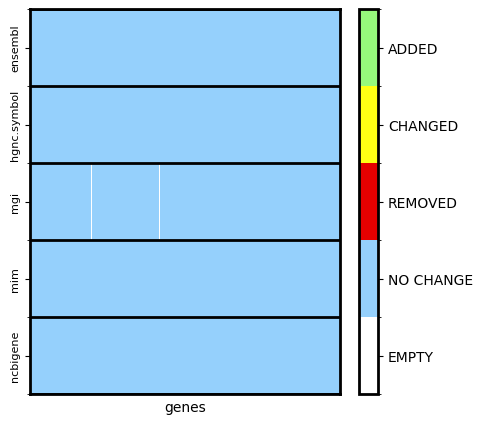

In [14]:
df_annotations = df_model_mim.loc[
    :, ["genes", "mim.all", "ncbigene", "hgnc.symbol", "ensembl", "mgi"]
]
df_annotations = df_annotations.rename({"mim.all": "mim"}, axis=1)
df_annotations = df_annotations.drop_duplicates()
df_annotations = df_annotations.groupby("genes", as_index=False).agg(
    lambda x: build_string(sorted(x.dropna()))
)
df_annotations = df_annotations.replace(float("nan"), pd.NA).replace("", pd.NA)
if compare:
    compare_on_index = [annotation_type]
    try:
        df_previous = pd.read_csv(
            annotation_dirpath / f"{annotation_type}_{db_tag}.tsv",
            sep="\t",
            index_col=None,
            dtype=str,
        )
        df_previous = df_previous.replace(float("nan"), pd.NA).replace("", pd.NA)
    except FileNotFoundError:
        df_previous = pd.DataFrame([], columns=compare_on_index)
    df_comparision = compare_tables(
        df_previous.set_index(compare_on_index),
        df_annotations.set_index(compare_on_index),
    )

    fig, ax = plt.subplots(1, 1, figsize=compare_figsize)
    ax.yaxis.set_tick_params(labelsize=8)
    ax = visualize_comparison(df_comparision)

if display_nunique:
    for col in df_annotations.columns:
        df = (
            df_annotations[col]
            .apply(lambda x: split_string(x))
            .explode(col)
            .drop_duplicates()
        )
        print(f"{df.name}: {df.nunique()}")
if overwrite:
    df_annotations.to_csv(
        annotation_dirpath / f"{annotation_type}_{db_tag}.tsv", sep="\t", index=False
    )

df_annotations

In [15]:
df_model_mim = df_annotations[["genes", "mim"]].copy()
df_model_mim["mim"] = df_model_mim["mim"].apply(lambda x: split_string(x))
df_model_mim = df_model_mim.explode("mim").drop_duplicates()
df_model_mim

df_model_mim = pd.merge(df_model_mim, df_mim[["mim", "type"]])
df_model_mim = df_model_mim.merge(df_mimtitles).drop_duplicates().reset_index(drop=True)
df_duplicated = df_model_mim[df_model_mim[["mim", "type"]].duplicated()].reset_index(
    drop=True
)
print(df_model_mim[["mim", "type"]].drop_duplicates()["type"].value_counts())
print("Duplicated:\t", df_duplicated["mim"].count())
df_model_mim

type
gene                        814
phenotype                   570
gene/phenotype                3
predominantly phenotypes      2
Name: count, dtype: int64
Duplicated:	 22


,genes,mim,type,title,title.symbol
0,A4GALT,111400,phenotype,"BLOOD GROUP, P1PK SYSTEM",
1,A4GALT,607922,gene,"ALPHA-1,4-GALACTOSYLTRANSFERASE",A4GALT
2,AARS1,601065,gene,ALANYL-tRNA SYNTHETASE 1,AARS1
3,AARS1,613287,phenotype,"CHARCOT-MARIE-TOOTH DISEASE, AXONAL, TYPE 2N",CMT2N
4,AARS1,616339,phenotype,DEVELOPMENTAL AND EPILEPTIC ENCEPHALOPATHY 29,DEE29
...,...,...,...,...,...
1406,YES1,164880,gene,V-YES-1 YAMAGUCHI SARCOMA VIRAL ONCOGENE,YES1
1407,ZDHHC2,618621,gene,ZINC FINGER DHHC-TYPE PALMITOYLTRANSFERASE 2,ZDHHC2
1408,ZDHHC20,617972,gene,ZINC FINGER DHHC DOMAIN-CONTAINING PROTEIN 20,ZDHHC20
1409,ZDHHC3,617150,gene,ZINC FINGER DHHC DOMAIN-CONTAINING PROTEIN 3,ZDHHC3


In [16]:
df_model_mim = df_annotations.copy()
df_model_mim["mim"] = df_model_mim["mim"].str.split(";")
df_model_mim = df_model_mim.explode("mim").drop_duplicates()
df_model_morbidmap = df_model_mim.merge(df_morbidmap)
df_model_morbidmap = df_model_morbidmap.loc[
    :,
    [
        "genes",
        "hgnc.symbol",
        "ncbigene",
        "mim",
        "mim.phenotype",
        "phenotype",
        "cyto.location",
    ],
]
if overwrite:
    df_model_morbidmap.to_csv(
        database_dirpath / f"{db_tag}_{GEM_NAME}_morbidmap.tsv", sep="\t"
    )

df_model_morbidmap

,genes,hgnc.symbol,ncbigene,mim,mim.phenotype,phenotype,cyto.location
0,A4GALT,A4GALT,53947,607922,111400,"NOR polyagglutination syndrome, 111400 (3)",22q13.2
1,A4GALT,A4GALT,53947,607922,111400,"[Blood group, P1Pk system, P(2) phenotype], 11...",22q13.2
2,A4GALT,A4GALT,53947,607922,111400,"[Blood group, P1Pk system, p phenotype], 11140...",22q13.2
3,AARS1,AARS1,16,601065,619661,"?Leukoencephalopathy, hereditary diffuse, with...",16q22.1
4,AARS1,AARS1,16,601065,613287,"Charcot-Marie-Tooth disease, axonal, type 2N, ...",16q22.1
...,...,...,...,...,...,...,...
637,WARS1,WARS1,7453,191050,617721,"Neuronopathy, distal hereditary motor, autosom...",14q32.2
638,WNK1,WNK1,65125,605232,201300,"Neuropathy, hereditary sensory and autonomic, ...",12p13.33
639,WNK1,WNK1,65125,605232,614492,"Pseudohypoaldosteronism, type IIC, 614492 (3)",12p13.33
640,YARS1,YARS1,8565,603623,608323,"Charcot-Marie-Tooth disease, dominant intermed...",1p35.1
